In [21]:
import pandas as pd
import os
data = ['dataSet_1','dataSet_2','dataSet_3','function_smoke_test']
requests = pd.read_json(os.path.join(data[0],'requests'),lines=True)
metas = pd.read_json(os.path.join(data[0],'metas'),lines=True)

In [22]:
requests['endTime'] = requests['startTime'] + requests['durationsInMs']
start_time = requests['startTime'].min()
requests = requests.sort_values(by=['metaKey', 'startTime'])
def calculate_idle_time(group):
    group = group.sort_values(by='endTime')
    group['next_startTime'] = group['startTime'].shift(-1)
    group['idle_time'] = group['next_startTime'] - group['endTime']
    return group

requests = requests.groupby('metaKey').apply(calculate_idle_time)
requests['idle_time'] = requests.apply(lambda row:row['startTime']-start_time if pd.isnull(row['idle_time']) else row['idle_time'],axis=1)
requests.loc[requests['idle_time'] < 0, 'idle_time'] = 0
requests['idle_time_in_sec'] = requests['idle_time'] /1000

In [23]:
# 将每个metaKey的idle_time_in_sec求直方图\
import numpy as np
def calculate_cv(series):
    hist, bin_edges = np.histogram(series, bins=100)
    hist_mean = hist.mean()
    hist_std = hist.std()
    cv = hist_std / hist_mean
    return cv 
requests.groupby(level='metaKey')['idle_time'].apply(calculate_cv)

metaKey
certificatesigningrequests1    9.949802
csinodes1                      7.040303
nodes1                         9.949334
rolebindings1                  9.949802
roles1                         9.949802
Name: idle_time, dtype: float64

In [18]:
idle_time_stats = requests.groupby(level='metaKey')['idle_time'].describe()
idle_time_stats_filtered = idle_time_stats[idle_time_stats['count'] > 10]
metas = metas.rename(columns={'key': 'metaKey'})
merged = metas.merge(idle_time_stats_filtered, on='metaKey', how='inner')



filtered = merged[['metaKey','25%','50%','75%']]
filtered = filtered.merge(requests.groupby(level='metaKey')['idle_time'].apply(calculate_cv),on='metaKey',how='inner')
# filtered['cv'] = requests.groupby(level='metaKey')['idle_time_in_sec'].apply(calculate_cv)
filtered = filtered.rename(columns={'idle_time':'cv'})
filtered
merged
# write to csv,mode:append
filtered.to_csv('idle_time_stats.csv',mode='a',header=False,index=False)

,metaKey,runtime,timeoutInSecs,memoryInMb,initDurationInMs,count,mean,std,min,25%,50%,75%,max
0,nodes1,go,627,512,49,18607.0,5.914404e+04,4.037466e+06,0.0,29940.0,29945.0,29948.0,550770000.0
1,roles1,go,129,256,56,418996.0,2.601024e+03,8.518763e+05,0.0,7.0,34.0,85.0,550738274.0
2,rolebindings1,go,491,256,13,418996.0,2.601456e+03,8.518763e+05,0.0,8.0,34.0,85.0,550738283.0
3,certificatesigningrequests1,go,541,256,20,418996.0,2.600407e+03,8.518694e+05,0.0,25.0,102.0,188.0,550738419.0
4,csinodes1,go,366,512,28,47.0,2.305970e+07,8.108839e+07,190438.0,1132124.5,3725278.0,8460204.5,549428583.0


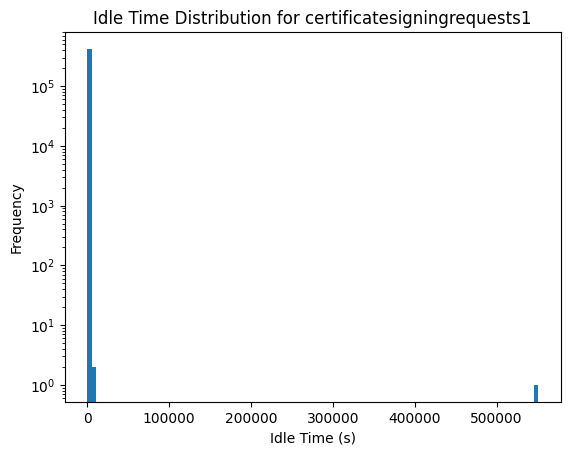

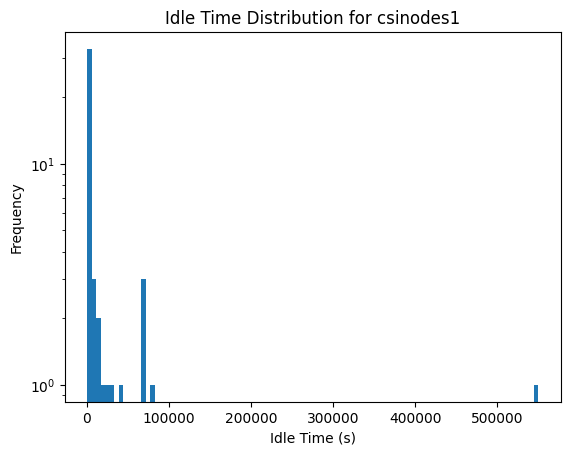

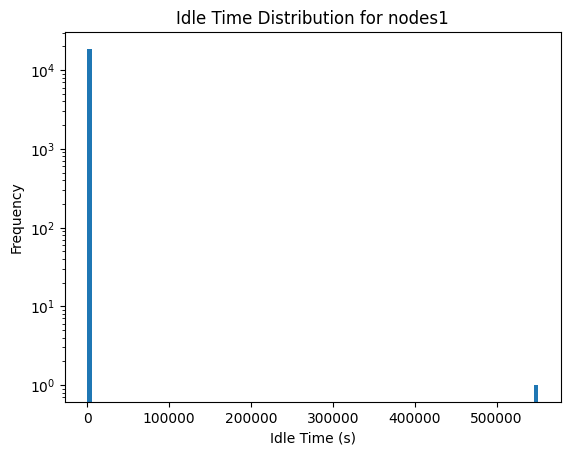

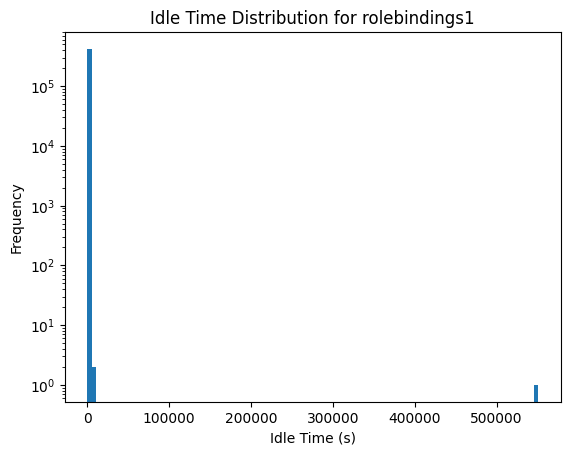

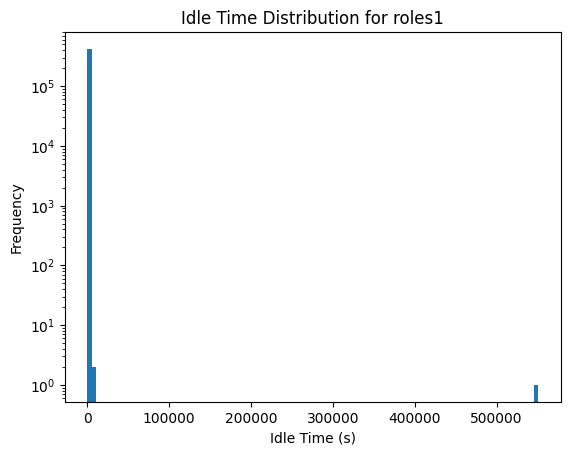

In [24]:
import matplotlib.pyplot as plt

# 获取所有唯一的metaKeys
meta_keys = requests['metaKey'].unique()

# 为每个metaKey创建一个直方图
for key in meta_keys:
    # 过滤掉请求次数小于10的metaKey
    if idle_time_stats.loc[key]['count'] < 10:
        continue
    #直方图，横坐标用log显示
    plt.hist(requests.loc[key]['idle_time_in_sec'],bins=100,log=True)

    
    
    plt.title(f'Idle Time Distribution for {key}')
    plt.xlabel('Idle Time (s)')
    plt.ylabel('Frequency')
    
    plt.show()